# Multi-class Classification

For this exercise, you will use logistic regression and neural networks to recognize handwritten digits (from 0 to 9). Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes) on mail envelopes to recognizing amounts written on bank checks. This exercise will show you how the methods you’ve learned can be used for this classification task.


In the first part of the exercise, you will extend your previous implemen- tion of logistic regression and apply it to one-vs-all classification.

In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.optimize import minimize
import scipy.optimize as opt
from IPython.display import Image
%matplotlib inline

data = loadmat('../data/ex3data1.mat')  
data

{'X': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 '__globals__': [],
 '__header__': 'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 'y': array([[10],
        [10],
        [10],
        ..., 
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

#### Visualize Data

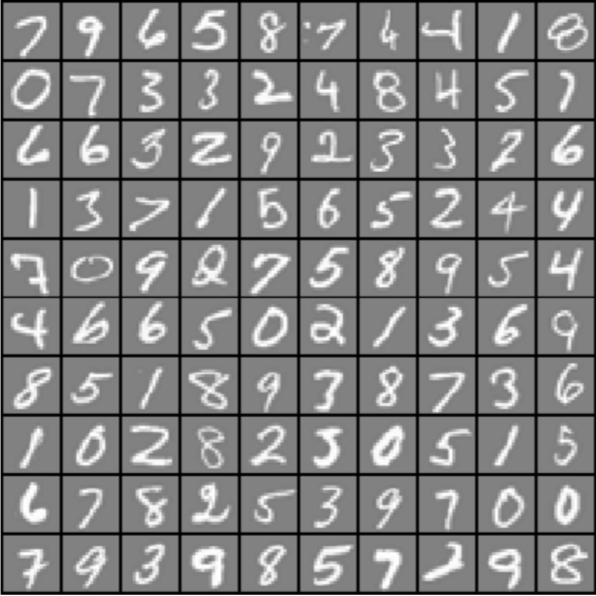

In [8]:
# import the number matrix here
Image(filename='../data/images/numberGrid.png')

The images are represented in martix X as a 400-dimensional vector (of which there are 5,000 of them). The 400 "features" are grayscale intensities of each pixel in the original 20 x 20 image. The class labels are in the vector y as a numeric class representing the digit that's in the image. There's an illustration below gives an example of what some of the digits look like. Each grey box with a white hand-drawn digit represents on 400-dimensional row in our dataset.

#### Cost Function

We need to implement a completely vectorized version of the cost function

In [10]:
def sigmoid(z):  
    return 1 / (1 + np.exp(-z))

def cost(theta, X, y, learningRate):  
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    reg = (learningRate / 2 * len(X)) * np.sum(np.power(theta[:,1:theta.shape[1]], 2))
    return np.sum(first - second) / (len(X)) + reg

#### Gradient Descent

Again we need this completely vectorized

In [20]:
def gradient(theta, X, y, learningRate):  
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)

    parameters = int(theta.ravel().shape[1])
    error = sigmoid(X * theta.T) - y

    grad = ((X.T * error) / len(X)).T + ((learningRate / len(X)) * theta)

    # intercept gradient is not regularized
    grad[0, 0] = np.sum(np.multiply(error, X[:,0])) / len(X)

    return np.array(grad).ravel()

#### One-vs-all Prediction

Since logistic regression is only able to distiguish between 2 classes at a time, we need a strategy to deal with the multi-class scenario.  Here we will will be implementing a one-vs-all approach, where each "k" (number 0-9) will have their own class.  We will be between between "class k" or "not class k".  Then we wrap the classifiers training into 1 function, computing the finals weights for each of the 10 classifiers.  This function will return the weights as kX(n + 1) array.

In [21]:
def one_vs_all(X, y, num_labels, learning_rate):  
    rows = X.shape[0]
    params = X.shape[1]

    # k X (n + 1) array for the parameters of each of the k classifiers
    all_theta = np.zeros((num_labels, params + 1))

    # insert a column of ones at the beginning for the intercept term
    X = np.insert(X, 0, values=np.ones(rows), axis=1)

    # labels are 1-indexed instead of 0-indexed
    for i in range(1, num_labels + 1):
        theta = np.zeros(params + 1)
        y_i = np.array([1 if label == i else 0 for label in y])
        y_i = np.reshape(y_i, (rows, 1))

        # minimize the objective function
        fmin = minimize(fun=cost, x0=theta, args=(X, y_i, learning_rate), method='TNC', jac=gradient)
        all_theta[i-1,:] = fmin.x

    return all_theta

In [23]:
all_theta = one_vs_all(data['X'], data['y'], 10, 1)

Here we are computing the class probability for each class, for each training instance, and assigning the output class label as the class with the highest probability.

In [18]:
def predict_all(X, all_theta):  
    rows = X.shape[0]
    params = X.shape[1]
    num_labels = all_theta.shape[0]

    # same as before, insert ones to match the shape
    X = np.insert(X, 0, values=np.ones(rows), axis=1)

    # convert to matrices
    X = np.matrix(X)
    all_theta = np.matrix(all_theta)

    # compute the class probability for each class on each training instance
    h = sigmoid(X * all_theta.T)

    # create array of the index with the maximum probability
    h_argmax = np.argmax(h, axis=1)

    # because our array was zero-indexed we need to add one for the true label prediction
    h_argmax = h_argmax + 1

    return h_argmax

Now we can use the predict_all function to generate class predictions for each instance and see how well our classifier works.

In [19]:
y_pred = predict_all(data['X'], all_theta)  
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, data['y'])]  
accuracy = (sum(map(int, correct)) / float(len(correct)))  
print 'accuracy = {0}%'.format(accuracy * 100)

accuracy = 97.36%
